In [34]:
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from PIL import Image
from sklearn.neural_network import MLPClassifier


%matplotlib inline

### Here I load dataset and include my face (9 photos) in it

In [95]:
lfw_data = datasets.fetch_lfw_people(min_faces_per_person=10)

Here I add my face into this dataset

In [96]:
jenya = []
for i in range(9):
    jenya.append(np.asarray(Image.open("j/%s.jpg" % (i+1)) ).reshape(1, -1)[0][::3])
jenya = np.array(jenya)
jenya_target = 158

In [97]:
X, y = lfw_data['data'], lfw_data['target']
X = np.concatenate((X, jenya), axis=0)

y_new = np.zeros(4333)
y_new[:-9] = y
for i in range(9):
    y_new[-i-1] = jenya_target
    
y = y_new

### Data spliting

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=13, stratify=y)
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train, train_size=0.75, stratify=y_train)

In [99]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_data.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
n_features = X.shape[1]

# the label to predict is the id of the person
target_names = lfw_data.target_names
my_name = np.array(['Eugene Marshakov'])
target_names = np.concatenate((target_names, my_name), axis=0)


n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 4324
n_features: 2914
n_classes: 159


In [100]:
from sklearn.decomposition import PCA, KernelPCA
from time import time

In [101]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4, eugene=False):
    
    """Helper function to plot a gallery of portraits"""
    if eugene == False:
        plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
        plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
        for i in range(n_row * n_col):
            plt.subplot(n_row, n_col, i + 1)
            plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
            plt.title(titles[i], size=12)
            plt.xticks(())
            plt.yticks(())
    else:
        plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
        plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
        for i in range(n_row * n_col - 1 ):
            plt.subplot(n_row, n_col, i + 1)
            plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
            plt.title(titles[i], size=12)
            plt.xticks(())
            plt.yticks(())
        place = prediction_titles.index('predicted: Marshakov\ntrue:      Marshakov')
        plt.subplot(n_row, n_col, n_row * n_col)
        plt.imshow(images[place].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[place], size=12)
        plt.xticks(())
        plt.yticks(())
        
# plot the result of the prediction on a portion of the test set
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[int(y_pred[i])].rsplit(' ', 1)[-1]
    true_name = target_names[int(y_test[i])].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

### PCA to 150-dimensional space

In [102]:
n_components = 150

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
# print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
# print("done in %0.3fs" % (time() - t0)

Extracting the top 150 eigenfaces from 3033 faces
Projecting the input data on the eigenfaces orthonormal basis


In [103]:
# plot_gallery(X_train, y_train, h, w)

In [104]:
# eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
# plot_gallery(eigenfaces, eigenface_titles, h, w)

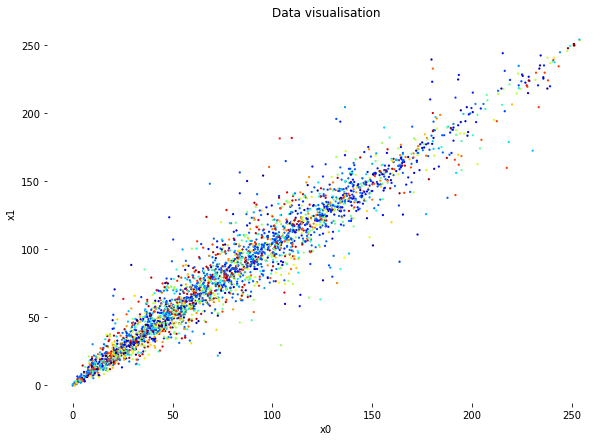

In [105]:
# plot data
x0 = [x[0] for x in X_train]
x1 = [x[1] for x in X_train]
colors = [cm.jet((y_) / max(y_train)) for y_ in y_train]
plt.figure(figsize=(10, 7))
ax = plt.axes(frameon=False)
plt.scatter(x0, x1, c=colors, edgecolor = 'none', s = 5)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Data visualisation')

### KernelPCA to 2D

In [106]:
# make PCA embedding from 901d into 2d space
print('Reduction...')
print('Original dimension: {}'.format(len(train_data[0])))
pca = KernelPCA(n_components=2, kernel='cosine')
pca.fit(X_train)
train = pca.transform(X_train)
print('Reduced dimension: {}'.format(len(train[0])))

Reduction...
Original dimension: 2914
Reduced dimension: 2


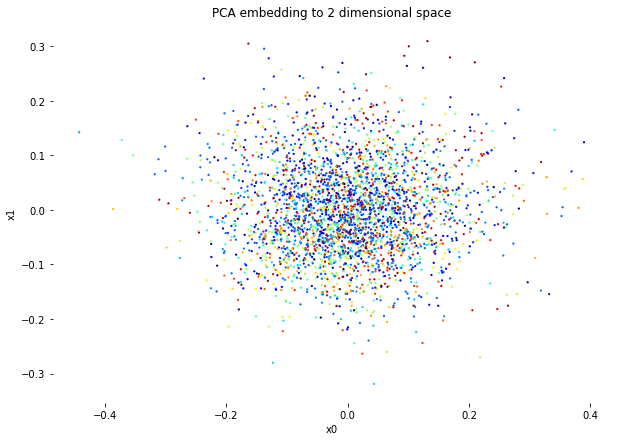

In [107]:
# plot data
x0 = [x[0] for x in train]
x1 = [x[1] for x in train]
colors = [cm.jet((y_) / max(y_train)) for y_ in train_label]
plt.figure(figsize=(10, 7))
ax = plt.axes(frameon=False)
plt.scatter(x0, x1, c=colors, edgecolor = 'none', s = 5)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('PCA embedding to 2 dimensional space');

### KernelPCA to 3D

In [108]:
print('Reduction...')
print('Original dimension: {}'.format(len(train_data[0])))
pca = KernelPCA(n_components=3, kernel='cosine')
pca.fit(X_train)
train = pca.transform(X_train)
print('Reduced dimension: {}'.format(len(train[0])))

Reduction...
Original dimension: 2914
Reduced dimension: 3


In [109]:
colors = [cm.jet((y_) / max(y_train)) for y_ in train_label]

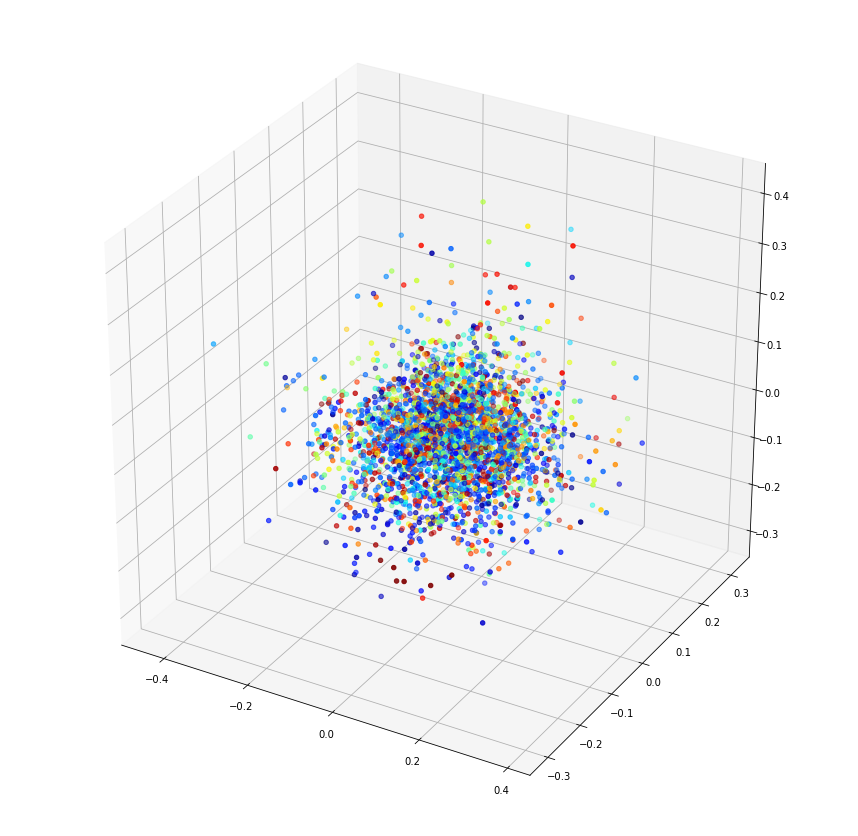

In [110]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(train[:, 0], train[:, 1], train[:, 2], c=colors)
plt.show()

In [111]:
# one_person_ind = np.where(y_train == 158)[0]
# one_person = train[one_person_ind]
# one_person_label = train[one_person_ind]

# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure(figsize=(15, 15))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(one_person[:, 0], one_person[:, 1], one_person[:, 2], c=colors)
# plt.show()

### SVM

In [112]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 570.922s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [113]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
# print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 2.014s
                           precision    recall  f1-score   support

             Abdullah Gul       0.60      0.50      0.55         6
             Adrien Brody       1.00      0.50      0.67         4
         Alejandro Toledo       0.53      0.75      0.62        12
             Alvaro Uribe       0.62      0.45      0.53        11
          Amelie Mauresmo       0.50      0.50      0.50         6
             Andre Agassi       0.50      0.18      0.27        11
             Andy Roddick       0.33      0.25      0.29         4
           Angelina Jolie       0.17      0.17      0.17         6
              Ann Veneman       0.00      0.00      0.00         3
          Anna Kournikova       0.00      0.00      0.00         4
            Ari Fleischer       1.00      0.50      0.67         4
             Ariel Sharon       0.49      0.91      0.64        23
    Arnold Schwarzenegger       0.05      0.08      0.06        13
    

//anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# YOU CAN SEE MY FACE!

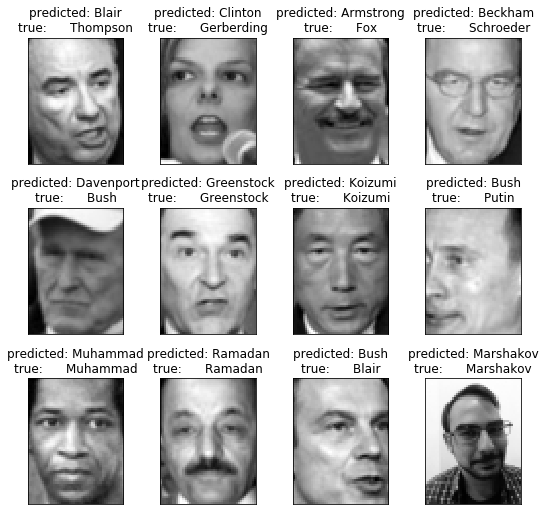

In [114]:
# plot the result of the prediction on a portion of the test set
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w, eugene=True)

In [161]:
# # plot the gallery of the most significative eigenfaces

# eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
# plot_gallery(eigenfaces, eigenface_titles, h, w)

# plt.show()

In [163]:
# for i in range(len(y_test)):
#     if y_test[i] == 158:
#         print (i)

### Logisitic regression
Here we find the best parameters for Logisic Regression. We see worse results then in SVM

In [151]:
print('Reduction...')
print('Original dimension: {}'.format(len(train_data[0])))
pca = PCA(n_components=110, whiten=True)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print('Reduced dimension: {}'.format(len(X_train_pca[0])))

Reduction...
Original dimension: 2914
Reduced dimension: 110


In [152]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e-3, 1e-4, 1e-5, 1, 1e3, 1e4, 1e5],
              'penalty': ['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 500.834s
Best estimator found by grid search:
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [153]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
# print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.007s
                           precision    recall  f1-score   support

             Abdullah Gul       0.30      0.50      0.37         6
             Adrien Brody       1.00      0.25      0.40         4
         Alejandro Toledo       0.47      0.58      0.52        12
             Alvaro Uribe       0.60      0.27      0.37        11
          Amelie Mauresmo       0.75      0.50      0.60         6
             Andre Agassi       0.11      0.09      0.10        11
             Andy Roddick       1.00      0.25      0.40         4
           Angelina Jolie       0.20      0.17      0.18         6
              Ann Veneman       0.00      0.00      0.00         3
          Anna Kournikova       1.00      0.25      0.40         4
            Ari Fleischer       1.00      0.50      0.67         4
             Ariel Sharon       0.50      0.70      0.58        23
    Arnold Schwarzenegger       0.00      0.00      0.00        13
    

//anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### MLPClassifier

In [141]:
print('Reduction...')
print('Original dimension: {}'.format(len(train_data[0])))
pca = PCA(n_components=100, whiten=True)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print('Reduced dimension: {}'.format(len(X_train_pca[0])))

Reduction...
Original dimension: 2914
Reduced dimension: 100


In [146]:
mlp = MLPClassifier(hidden_layer_sizes=(1000, 1000), solver='lbfgs', max_iter=1500)

In [147]:
mlp.fit(X_train_pca, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1000, 1000), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [148]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = mlp.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
# print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.129s
                           precision    recall  f1-score   support

             Abdullah Gul       0.57      0.67      0.62         6
             Adrien Brody       0.50      0.25      0.33         4
         Alejandro Toledo       0.43      0.75      0.55        12
             Alvaro Uribe       0.67      0.36      0.47        11
          Amelie Mauresmo       0.43      0.50      0.46         6
             Andre Agassi       0.29      0.18      0.22        11
             Andy Roddick       0.25      0.25      0.25         4
           Angelina Jolie       0.14      0.17      0.15         6
              Ann Veneman       0.00      0.00      0.00         3
          Anna Kournikova       0.00      0.00      0.00         4
            Ari Fleischer       0.67      0.50      0.57         4
             Ariel Sharon       0.52      0.61      0.56        23
    Arnold Schwarzenegger       0.14      0.15      0.15        13
    

//anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The result is similar with SVM

In [149]:
np.logspace(-4, 4, 3)

array([  1.00000000e-04,   1.00000000e+00,   1.00000000e+04])